# Otimizando Geometrias usando VASP e ASE

Autor: [Prof. Elvis do A. Soares](https://github.com/elvissoares) 

Contato: [elvis@peq.coppe.ufrj.br](mailto:elvis@peq.coppe.ufrj.br) - [Programa de Engenharia Química, PEQ/COPPE, UFRJ, Brasil](https://www.peq.coppe.ufrj.br/)

---

Importando variáveis do VASP

In [1]:
import os
# Definindo o path para os arquivos de potencial de pseudopotenciais do VASP
# Certifique-se de que o caminho esteja correto para o seu sistema
os.environ['VASP_PP_PATH'] = '/home/elvis/Programs/vasp-6.5.1/pp'
os.environ['ASE_VASP_COMMAND'] = 'mpirun -np 1 vasp_std_cpu'
os.environ['NO_STOP_MESSAGE'] = '1' # to avoid warning from mpirun

# Importando o VASP calculator do ASE
from ase.calculators.vasp import Vasp

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from ase import Atoms, Atom
from ase.build import molecule
from ase.io import write, read
from ase.calculators.vasp import Vasp
from ase.visualize.plot import plot_atoms
from ase.visualize import view

# Geometria de Moléculas

## Molécula de H2O


Uma opção para gerar geometria da molécula

In [122]:
h2omol = Atoms([Atom('O', [0, 0, 0]),
                Atom('H', [0.0, -0.760265, 0.588373]),
                Atom('H', [0.0, 0.760265, 0.588373])])
h2omol.center(vacuum=4.0) 
h2omol.pbc = True 

<Axes: >

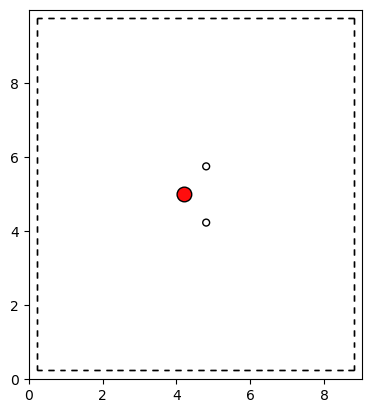

In [5]:
fig, ax = plt.subplots()
plot_atoms(h2omol, ax, radii=0.3, rotation=('0x,90y,0z'))

In [6]:
view(h2omol, viewer='x3d')

Calculando comprimendo da ligação

In [7]:
l = h2omol.get_distance(0, 1)

print(f"O comprimento da ligação O-H é {l:.3f} Å")

O comprimento da ligação O-H é 0.961 Å


Calculando o ângulo da ligação

In [8]:
theta = h2omol.get_angle(2, 0, 1)

print(f"O ângulo da ligação H-O-H é {theta:.3f} graus")

O ângulo da ligação H-O-H é 104.527 graus


ASE possui algumas moléculas já pré-definidas

In [ ]:
h2omol = molecule('H2O')        # molécula
h2omol.center(vacuum=4.0)       # ~8 Å box; 4 Å para cada lado, bom para isolar molécula
h2omol.pbc = True               # aplica condição de contorno periódica

<Axes: >

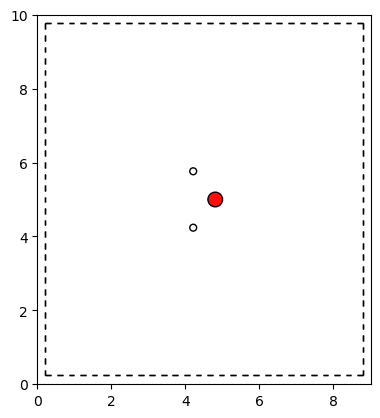

In [10]:
fig, ax = plt.subplots()
plot_atoms(h2omol, ax, radii=0.3, rotation=('0x,90y,0z'))

In [11]:
calc = Vasp(xc='PBE',                                   # funcional
            encut=350,                                  # safe default for PAW-PBE sets
            kpts=[1, 1, 1],gamma=True,                  # Somente pontos Gamma em Fourier
            ibrion=-1,                                  # Calcula sem atualizar posições atômicas
            directory='moleculas/H2O'                   # pasta em que os cálculos serão armazenados
        )

In [12]:
h2omol.calc = calc

In [13]:
E0 = h2omol.get_potential_energy()       

print('Energia: {:.3f} eV'.format(E0))

Energia: -14.219 eV


<Axes: >

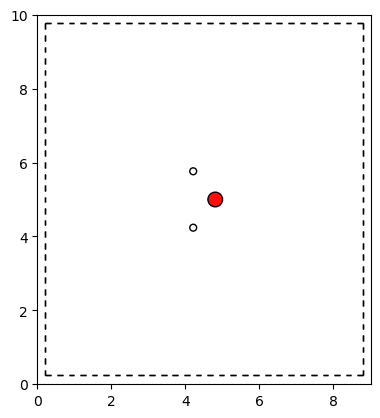

In [14]:
fig, ax = plt.subplots()
plot_atoms(h2omol, ax, radii=0.3, rotation=('0x,90y,0z'))

In [15]:
print("Posições (Å):\n", h2omol.get_positions())

Posições (Å):
 [[4.       4.763239 4.596309]
 [4.       5.526478 4.      ]
 [4.       4.       4.      ]]


In [16]:
l = h2omol.get_distance(0, 1)

print(f"O comprimento da ligação O-H é {l:.3f} Å")

O comprimento da ligação O-H é 0.969 Å


In [17]:
theta = h2omol.get_angle(2, 0, 1)

print(f"O ângulo da ligação H-O-H é {theta:.3f} graus")

O ângulo da ligação H-O-H é 104.000 graus


### Variando parâmetros do VASP

Checando a convergência com o tamanho da caixa

In [18]:
Larray = np.array([6.0, 8.0, 10.0, 12.0,14.0]) # tamanhos da caixa
Earray = np.zeros(len(Larray))

for i, L in enumerate(Larray):
    h2omol.center(vacuum=L/2.0)    # box de tamanho L

    calc = Vasp(xc='PBE',                                   # funcional
                encut=350,                                  # safe default for PAW-PBE sets
                kpts=[1, 1, 1],gamma=True,                  # Somente pontos Gamma em Fourier
                ibrion=-1,                                  # Sem atualizar posições atômicas
                directory=f'moleculas/H2O/L-{int(L)}',       # pasta em que os cálculos serão armazenados
                atoms = h2omol                           
            )

    Earray[i] = h2omol.get_potential_energy()

    print(f"L = {L:.1f} Å, E = {Earray[i]:.3f} eV")

L = 6.0 Å, E = -14.193 eV
L = 8.0 Å, E = -14.219 eV
L = 10.0 Å, E = -14.217 eV
L = 12.0 Å, E = -14.219 eV
L = 14.0 Å, E = -14.221 eV


Text(0.5, 1.0, 'Convergência da energia da molécula de H2O com L')

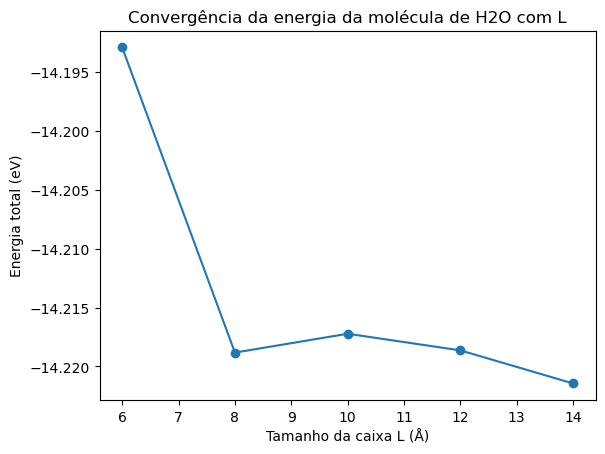

In [19]:
plt.plot(Larray, Earray, 'o-')
plt.xlabel('Tamanho da caixa L (Å)')
plt.ylabel('Energia total (eV)')
plt.title('Convergência da energia da molécula de H2O com L')

Checando convergência com `encut`

In [20]:
ENCUTarray = np.array([250,300,350,400,450,500]) # valores de ENCUT
Earray = np.zeros(len(ENCUTarray))

h2omol.center(vacuum=4.0)    # box de tamanho L

for i, encut in enumerate(ENCUTarray):
    
    calc = Vasp(xc='PBE',                                   # funcional
                encut=encut,                                # safe default for PAW-PBE sets
                kpts=[1, 1, 1],gamma=True,                  # Somente pontos Gamma em Fourier
                ibrion=-1,                                  # Sem atualizar posições atômicas
                directory=f'moleculas/H2O/encut-{encut}',   # pasta em que os cálculos serão armazenados
                atoms = h2omol                           
            )

    Earray[i] = h2omol.get_potential_energy()

    print(f"ENCUT = {encut:.1f} Å, E = {Earray[i]:.3f} eV")

ENCUT = 250.0 Å, E = -14.378 eV
ENCUT = 300.0 Å, E = -14.265 eV
ENCUT = 350.0 Å, E = -14.219 eV
ENCUT = 400.0 Å, E = -14.217 eV
ENCUT = 450.0 Å, E = -14.213 eV
ENCUT = 500.0 Å, E = -14.214 eV


Text(0.5, 1.0, 'Convergência da energia da molécula de H2O com ENCUT')

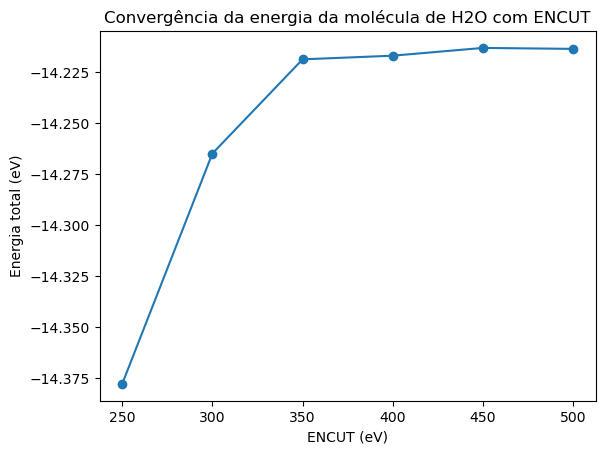

In [21]:
plt.plot(ENCUTarray, Earray, 'o-')
plt.xlabel('ENCUT (eV)')
plt.ylabel('Energia total (eV)')
plt.title('Convergência da energia da molécula de H2O com ENCUT')

### Otimizando a geometria da molécula de H2O

In [ ]:
THETAarray = np.array([90,95, 100, 105, 110, 115, 120]) # valores de ângulos de ligação
Earray = np.zeros(len(THETAarray))

for i, theta in enumerate(THETAarray):
    h2omol.set_angle(2, 0, 1, theta)  # fixa o oxigênio e altera o ângulo H-O-H

    calc = Vasp(xc='PBE',                                   # funcional
                encut=350,                                  # safe default for PAW-PBE sets
                kpts=[1, 1, 1],gamma=True,                  # Somente pontos Gamma em Fourier
                ibrion=-1,                                  # Sem atualizar posições atômicas
                directory=f'moleculas/H2O/theta-{int(theta)}', # pasta em que os cálculos serão armazenados
                atoms = h2omol                           
            )

    Earray[i] = h2omol.get_potential_energy()

    print(f"theta = {theta:.1f}°, E = {Earray[i]:.3f} eV")

theta = 90.0°, E = -14.060 eV
theta = 95.0°, E = -14.148 eV
theta = 100.0°, E = -14.199 eV
theta = 105.0°, E = -14.215 eV
theta = 110.0°, E = -14.199 eV
theta = 115.0°, E = -14.154 eV
theta = 120.0°, E = -14.084 eV


Text(0.5, 1.0, 'Energia da molécula de H2O vs. ângulo de ligação')

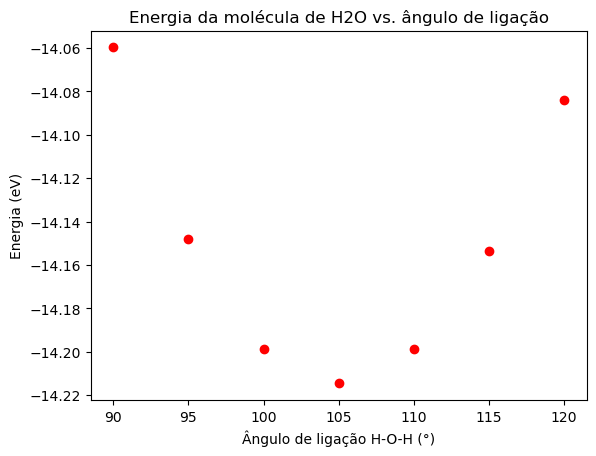

In [133]:
plt.plot(THETAarray, Earray, 'or')
plt.xlabel('Ângulo de ligação H-O-H (°)')
plt.ylabel('Energia (eV)')
plt.title('Energia da molécula de H2O vs. ângulo de ligação')

Fitting parabólico

In [ ]:
z = np.polyfit(THETAarray, Earray, 2)

print(z)

p = np.poly1d(z)

[ 6.34546567e-04 -1.33852925e-01 -7.15580819e+00]


In [ ]:



print(f"A energia mínima é {p.r[0]:.3f} eV no ângulo { -z[1]/(2*z[0]):.3f}°")

A energia mínima é 255.142 eV no ângulo 105.471°


Text(0.5, 1.0, 'Energia da molécula de H2O vs. ângulo de ligação')

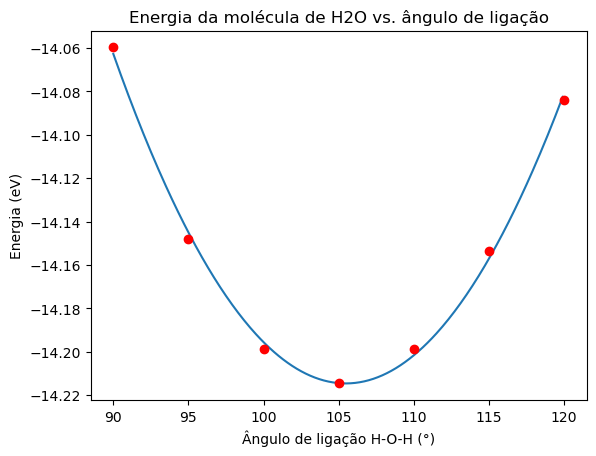

In [ ]:
thetarray = np.arange(THETAarray[0], THETAarray[-1]+0., 0.1)

plt.plot(thetarray, p(thetarray), '-', label='Fitting parabólico')


plt.plot(THETAarray, Earray, 'or')
plt.xlabel('Ângulo de ligação H-O-H (°)')
plt.ylabel('Energia (eV)')
plt.title('Energia da molécula de H2O vs. ângulo de ligação')

### Forças nos núcleos atômicos

Sendo a energia total de uma molécula dada por $E[\rho(\boldsymbol{r})]$ calculada a partir do DFT por 
$$E[\rho(\boldsymbol{r})]= E_{HK}[\rho(\boldsymbol{r})] - \sum_{A=1}^M \int \frac{Z_A}{|\boldsymbol{r}-\boldsymbol{R_A}|} \rho(\boldsymbol{r})\ \text{d} \boldsymbol{r} + \frac{1}{2}\sum_{A=1}^M \sum_{B\neq A}^M \frac{Z_A Z_B}{|\boldsymbol{R}_B-\boldsymbol{R_A}|} $$
de tal forma que a força experimentada por um núcleo $C$ seja dada por 
$$\boldsymbol{F}_C = -\frac{\partial E}{\partial \boldsymbol{R}_C}$$
que é uma consequência do **teorema de Hellmann-Feynman**. Usando o DFT podemos calcular essa força a partir de 
$$ \frac{\partial E}{\partial \boldsymbol{R}_C}=\frac{\partial }{\partial \boldsymbol{R}_C}\left[- \sum_{A=1}^M \int \frac{Z_A}{|\boldsymbol{r}-\boldsymbol{R_A}|} \rho(\boldsymbol{r})\ \text{d} \boldsymbol{r} + \frac{1}{2}\sum_{A=1}^M \sum_{B\neq A}^M \frac{Z_A Z_B}{|\boldsymbol{R}_B-\boldsymbol{R_A}|} \right]$$
de modo que a força experimentada pelos núcleos atômicos é proporcional ao campo elétrico gerado pelos elétrons e pelos demais núcleos. Com isso, chegamos a 
$$ \frac{\partial E}{\partial \boldsymbol{R}_C}=- \int \frac{Z_C (\boldsymbol{r}-\boldsymbol{R_C})}{|\boldsymbol{r}-\boldsymbol{R_C}|^3} \rho(\boldsymbol{r})\ \text{d} \boldsymbol{r} + \sum_{A\neq C}^M \frac{Z_A Z_C (\boldsymbol{R}_A-\boldsymbol{R_C})}{|\boldsymbol{R}_A-\boldsymbol{R_C}|^3} $$


No VASP, os métodos de otimização de estrutura são definidos por 
- `ibrion=1` RMM-DIIS (combinação linear das posições anteriores, mais rapidos)
- `ibrion=2` conjugate gradient (mais robusto)
- `ibrion=3` damped molecular dynamics (MD com velocidade diminuindo, para sistemas grandes e longe do equilíbrio)

REF: https://www.vasp.at/wiki/Structure_optimization

In [151]:
h2omol = molecule('H2O')        # molécula
h2omol.center(vacuum=4.0)      # ~8 Å box; 4 Å para cada lado, bom para isolar molécula
h2omol.pbc = True               # aplica condição de contorno periódica

In [152]:
calc = Vasp(xc='PBE',                                   # funcional
            encut=350,                                  # safe default for PAW-PBE sets
            kpts=[1, 1, 1],gamma=True,                  # Somente pontos Gamma em Fourier
            ismear=0,                                   # smearing gaussiano (moléculas = 0)
            ibrion=2,                                   # CG iônico, relaxa ions somente
            prec='High',                                # precisão do cálculo
            nsw=100,                                    # Número de passos iônicos
            directory='moleculas/H2O/relaxed',          # pasta em que os cálculos serão armazenados
            atoms=h2omol
        )

In [153]:
E_relax = h2omol.get_potential_energy()       

print('Energia: {:.3f} eV'.format(E_relax))

Energia: -14.225 eV


In [154]:
E_relax-E0

np.float64(0.6169337854568528)

In [161]:
view(h2omol, viewer='x3d')

In [155]:
print("Número de passos executados:", calc.get_number_of_iterations())

Número de passos executados: 3


In [156]:
print("Forças em ev/A")
print("=======")
print(h2omol.get_forces())

Forças em ev/A
[[ 0.          0.         -0.06145712]
 [ 0.          0.02873979  0.03072856]
 [ 0.         -0.02873979  0.03072856]]


In [157]:
l = h2omol.get_distance(0, 1)

print(f"O comprimento da ligação O-H é {l:.3f} Å")

O comprimento da ligação O-H é 0.973 Å


In [158]:
theta = h2omol.get_angle(2, 0, 1)

print(f"O ângulo da ligação H-O-H é {theta:.3f} graus")

O ângulo da ligação H-O-H é 103.810 graus


### Analisando Orbitais Moleculares

Determinando as energias dos orbitais moleculares

In [30]:
calc.get_eigenvalues()

array([-25.1776, -12.9503,  -9.1372,  -7.0667,  -1.0205,   0.7997,
         0.8036,   1.4555])

Determinando as ocupações

In [31]:
calc.get_occupation_numbers()

array([2., 2., 2., 2., 0., 0., 0., 0.])

Determinando as energias dos orbitais HOMO e LUMO

In [32]:
homo, lumo = calc.get_homo_lumo()

print(f"Lumo: {lumo:.3f} eV")
print(f"Homo: {homo:.3f} eV")
print('----------')
print(f"Diferença: {lumo-homo:.3f} eV")

Lumo: -1.020 eV
Homo: -7.067 eV
----------
Diferença: 6.046 eV


HOMO = -7.067 eV, LUMO = -1.020 eV, GAP = 6.046 eV


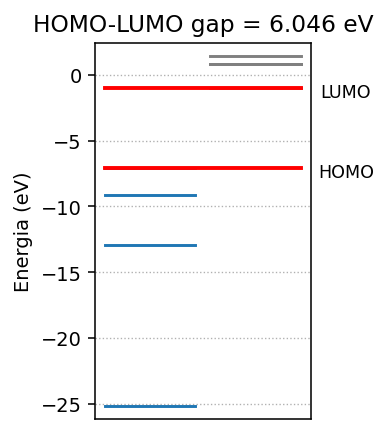

In [33]:
gap = (lumo - homo)

# Eigenvalues and occupations (Kohn–Sham levels)
eigs = np.array(calc.get_eigenvalues())
occ  = np.array(calc.get_occupation_numbers())

# Sort for a clean plot
order = np.argsort(eigs)
eigs, occ = eigs[order], occ[order]

# Split occupied / unoccupied
occ_mask = occ > 0.5
E_occ = eigs[occ_mask]
E_unocc = eigs[~occ_mask]

# --- plotting (single chart, no explicit colors) ---
plt.figure(figsize=(3, 3.2), dpi=140)

# Sticks for occupied and unoccupied states
for E in E_occ:
    plt.plot([0, 0.6], [E, E],color='C0')
for E in E_unocc:
    plt.plot([0.7, 1.3], [E, E],color='grey')

# Highlight HOMO / LUMO
plt.plot([0, 1.3],[homo, homo],color='red', linewidth=2)
plt.plot([0, 1.3],[lumo, lumo],color='red', linewidth=2)

# Annotate
plt.text(1.6,homo-1, 'HOMO', ha='center', va='bottom', fontsize=9)
plt.text(1.6, lumo-1, 'LUMO', ha='center', va='bottom', fontsize=9)
plt.title(f'HOMO-LUMO gap = {gap:.3f} eV')

plt.ylabel('Energia (eV)')
plt.xticks([])          # hide y-axis (pure spectrum)
plt.ylim(min(eigs)-1, max(eigs)+1)
plt.grid(True, axis='y', linestyle=':', linewidth=0.7)
plt.tight_layout()

print(f"HOMO = {homo:.3f} eV, LUMO = {lumo:.3f} eV, GAP = {gap:.3f} eV")

In [34]:
print(f'Comprimento de onda da radiação pro gap é de {1239.8/gap:.3f} nm')

Comprimento de onda da radiação pro gap é de 205.054 nm


### Adicionando interação de van der Waals

$$E_\text{DFT+vDW} = E_\text{KS} - \frac{1}{2}\sum_{A=1}^M \sum_{B \neq A}^M \frac{C_{AB}}{|\boldsymbol{R}_A-\boldsymbol{R}_B|^6}$$

com $C_{AB} = (C_A C_B)^{1/2}$ é o coeficiente de dispersão calculado pela fórmula de Casimir-Polder

$$C_{AB} = \frac{3}{\pi}\int_0^\infty \alpha_A(i \omega ) \alpha_B (i \omega)\ \text{d}\omega$$

com $\alpha_i$ sendo a polarizabilidade do átomo $i$. 

No VASP, basta fazer `lvdw=True` no `calc`

In [35]:
calc_vdw = Vasp(directory="moleculas/H2O/vdw",
            xc="PBE",
            encut=350,
            kpts=[1, 1, 1],
            ibrion=2,
            nsw=100,
            lvtot=True,                           # exporta potencial eletrostático (LOCPOT file)
            lvdw=True,                            # ligando a interação de vdW
            atoms=h2omol)

In [36]:
Evdw = h2omol.get_potential_energy()   

In [37]:
print(Evdw-E0, ' eV')

-0.0021672200000004693  eV


In [39]:
homo, lumo = calc_vdw.get_homo_lumo()

gap = lumo-homo

print(f"Lumo: {lumo:.3f} eV")
print(f"Homo: {homo:.3f} eV")
print('----------')
print(f"Diferença: {gap:.3f} eV")

Lumo: -1.016 eV
Homo: -7.067 eV
----------
Diferença: 6.051 eV


In [40]:
print(f'Comprimento de onda da radiação pro gap é de {1239.8/gap:.3f} nm')

Comprimento de onda da radiação pro gap é de 204.888 nm


---

# Geometria de Sólidos

## Cristal de Cu

Criando a partir dos vetores da base do FCC

In [40]:
a = 2.53
Cu_crystal = Atoms([Atom("Cu", (0, 0, 0))],
                cell=0.5 * a * np.array([[1.0, 1.0, 0.0],
                [0.0, 1.0, 1.0],
                [1.0, 0.0, 1.0]]), pbc=True)

print(Cu_crystal)
print("Cell:", Cu_crystal.get_cell())
print("Positions:\n", Cu_crystal.get_positions())

Atoms(symbols='Cu', pbc=True, cell=[[1.265, 1.265, 0.0], [0.0, 1.265, 1.265], [1.265, 0.0, 1.265]])
Cell: Cell([[1.265, 1.265, 0.0], [0.0, 1.265, 1.265], [1.265, 0.0, 1.265]])
Positions:
 [[0. 0. 0.]]


In [41]:
view(Cu_crystal, viewer='x3d')

Criando a partir de arquivo CIF

Ref: https://legacy.materialsproject.org/materials/mp-30/

In [42]:
# Lendo arquivo CIF
Cu_crystal = read('structures/Cu.cif') # célula convencional

# See basic info
print(Cu_crystal)
print("Cell:", Cu_crystal.get_cell())
print("Positions:\n", Cu_crystal.get_positions())

Cu_crystal.get_number_of_atoms()

Atoms(symbols='Cu4', pbc=True, cell=[3.621262, 3.621262, 3.621262], spacegroup_kinds=...)
Cell: Cell([3.621262, 3.621262, 3.621262])
Positions:
 [[0.       0.       0.      ]
 [0.       1.810631 1.810631]
 [1.810631 0.       1.810631]
 [1.810631 1.810631 0.      ]]


/tmp/ipykernel_86926/2373156856.py:9: FutureWarning: Please use len(self) or, if your atoms are distributed, self.get_global_number_of_atoms.
  Cu_crystal.get_number_of_atoms()


4

In [43]:
view(Cu_crystal, viewer='x3d')

In [44]:
calc = Vasp(directory='solidos/Cu',
                xc='PBE',
                kpts=[6, 6, 6],  # specifies k-points
                encut=350,
                atoms = Cu_crystal)

In [45]:
E_Cu = Cu_crystal.get_potential_energy()

print(f'Energia total do cristal de Cu: {E_Cu:.3f} eV')

Energia total do cristal de Cu: -14.892 eV


In [46]:
E_per_Cu = E_Cu / len(Cu_crystal)

print(f'Energia por átomo de Cu {E_per_Cu:.3f} eV')

Energia por átomo de Cu -3.723 eV


### Otimizando parâmetros do VASP

Variando número de `kpoints`

In [94]:
KPTSarray = [2, 3, 4, 5, 6, 8, 10] # valores de k-points
Earray = np.zeros(len(KPTSarray))

for i, k in enumerate(KPTSarray):
    
    calc = Vasp(directory='solidos/Cu/kpoints-{0}'.format(k),
                xc='PBE',
                kpts=[k, k, k],  # specifies k-points
                encut=350,
                ibrion=-1,                                  # Sem atualizar posições atômicas
                atoms=Cu_crystal)

    Earray[i] = Cu_crystal.get_potential_energy()

    print(f"KPOINTS = {k:.1f}, E = {Earray[i]:.3f} eV")

KPOINTS = 2.0, E = -12.301 eV
KPOINTS = 3.0, E = -14.417 eV
KPOINTS = 4.0, E = -14.702 eV
KPOINTS = 5.0, E = -14.801 eV
KPOINTS = 6.0, E = -14.895 eV
KPOINTS = 8.0, E = -14.945 eV
KPOINTS = 10.0, E = -14.946 eV


Text(0, 0.5, 'Energia (eV)')

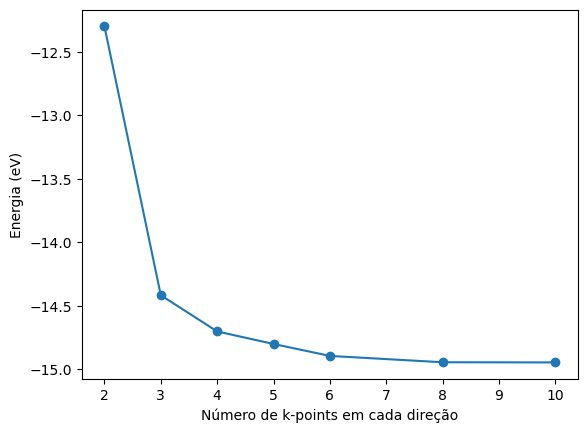

In [98]:
plt.plot(KPTSarray, Earray, 'o-')
plt.xlabel('Número de k-points em cada direção')
plt.ylabel('Energia (eV)')
# plt.ylim(-15,-14.8)

Variando o parâmetro `encut`

In [ ]:
ENCUTarray = np.array([250,300,350,400,450,500]) # valores de ENCUT
Earray = np.zeros(len(ENCUTarray))

for i, encut in enumerate(ENCUTarray):
    
    calc = Vasp(directory='solidos/Cu/encut-{0}'.format(encut),
                xc='PBE',
                kpts=[6, 6, 6],                        
                encut=encut,
                ibrion=-1,                                  # Sem atualizar posições atômicas
                atoms=Cu_crystal)

    Earray[i] = Cu_crystal.get_potential_energy()

    print(f"ENCUT = {encut:.1f} Å, E = {Earray[i]:.3f} eV")

ENCUT = 250.0 Å, E = -14.429 eV
ENCUT = 300.0 Å, E = -14.877 eV
ENCUT = 350.0 Å, E = -14.895 eV
ENCUT = 400.0 Å, E = -14.874 eV
ENCUT = 450.0 Å, E = -14.866 eV
ENCUT = 500.0 Å, E = -14.867 eV


Text(0, 0.5, 'Energia (eV)')

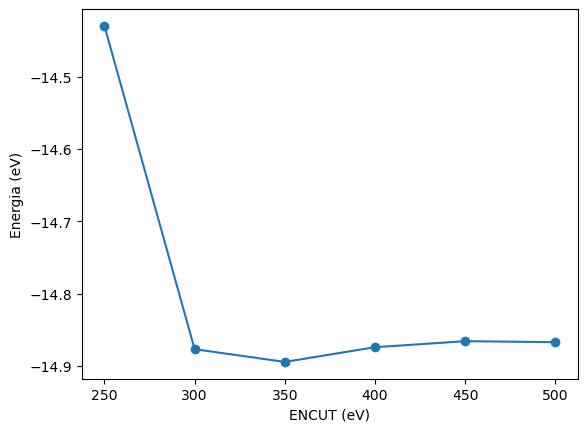

In [93]:
plt.plot(ENCUTarray, Earray,'o-')
plt.xlabel('ENCUT (eV)')
plt.ylabel('Energia (eV)')

### Otimizando o tamanho da célula cristalina

In [99]:
Cu_crystal.get_cell()

Cell([3.6352370954870388, 3.6352370954870388, 3.6352370954870388])

In [100]:
a_cell = np.array([ 3.2, 3.4, 3.6, 3.8, 4.0,4.2]) # valores em Angstrons
E_total = np.zeros_like(a_cell)

for i, a in enumerate(a_cell):
    Cu_crystal.set_cell([a, a, a], scale_atoms=True)

    calc = Vasp(directory='solidos/Cu/a-{:.1f}'.format(a),
                xc='PBE',
                kpts=[6, 6, 6],  # specifies k-points
                encut=300,
                atoms = Cu_crystal)
    
    E = Cu_crystal.get_potential_energy()
    E_total[i] = E
    print(f'a = {a: .2f} Å  -->  E = {E: .6f} eV')

a =  3.20 Å  -->  E = -10.411968 eV
a =  3.40 Å  -->  E = -13.862298 eV
a =  3.60 Å  -->  E = -14.853211 eV
a =  3.80 Å  -->  E = -14.568704 eV
a =  4.00 Å  -->  E = -13.633855 eV
a =  4.20 Å  -->  E = -12.410186 eV


Text(0.5, 1.0, 'Energia do Cristal de Cu vs. Parâmetro de Rede a')

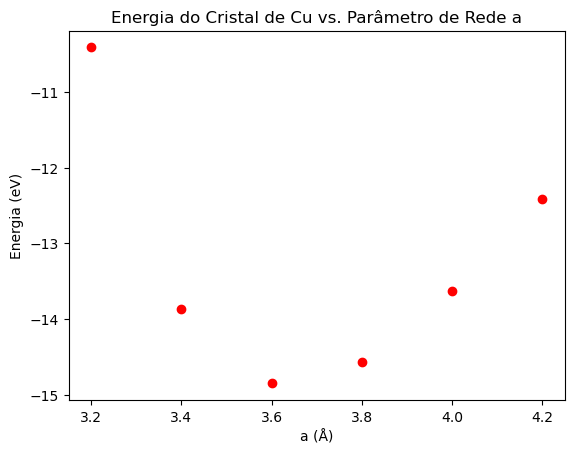

In [101]:
plt.plot(a_cell, E_total, 'or')
plt.xlabel('a (Å)')
plt.ylabel('Energia (eV)')
plt.title('Energia do Cristal de Cu vs. Parâmetro de Rede a')

Fitting de polinômio quadrático

In [102]:
z = np.polyfit(a_cell, E_total, 2)
p = np.poly1d(z)

#### Equação de Estado de Murnaghan

$$E(V) = E_0 + \frac{B_0 V}{B_0'}\left[\frac{(V_0/V)^{B_0'}}{B_0'-1}+1 \right] - \frac{B_0 V}{B_0'-1}$$

com 
- $V$: volume da célula unitária
- $V_0$: volume da célula unitária com energia mínima
- $B_0$: módulo de compressibilidade $B_0 = - V (\partial P /\partial V)_T$.
- $B_0'$: derivada do módulo de compressibilidade com a pressão

*Ref:* C. L. Fu and K. M. Ho. First-principles calculation of the equilibrium ground-state properties of transition metals: Applications to Nb and Mo. Phys. Rev. B, 28:5480–5486, Nov 1983. doi: [10.1103/PhysRevB.28.5480](http://link.aps.org/doi/10.1103/PhysRevB.28.5480).

In [103]:
def Murnaghan(a, a0, E0, B0, BP):
    vol = a**3
    V0 = a0**3
    return E0 + (B0*vol/BP)*(((V0/vol)**BP)/(BP-1)+1) - V0*B0/(BP-1)


from scipy.optimize import curve_fit

popt, pcov = curve_fit(Murnaghan, a_cell, E_total, p0=[a_cell[E_total.argmin()],E_total.min(),0.0,2.0])

a0 = popt[0]
E0 = popt[1]
B0 = popt[2]
BP = popt[3]

print(f'Fitted parameters: a0={a0:.4f} Å, E0={E0:.4f} eV, B0={B0:.4f} eV/Å³, BP={BP:.4f}')

Fitted parameters: a0=3.6381 Å, E0=-14.8420 eV, B0=0.7667 eV/Å³, BP=5.0418


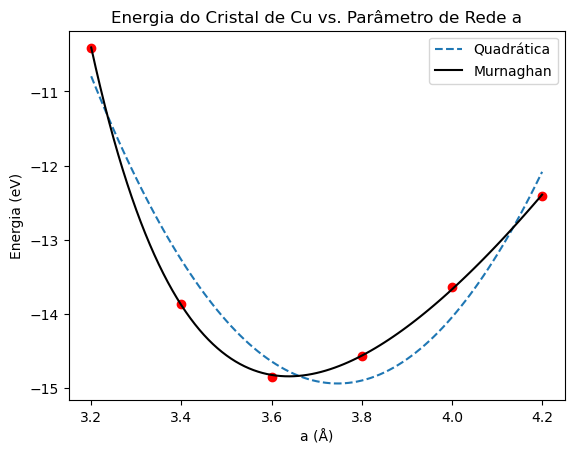

In [104]:
a_array = np.arange(a_cell[0], a_cell[-1]+0.01, 0.01)

plt.plot(a_cell, E_total, 'or')
plt.plot(a_array, p(a_array), '--',label='Quadrática')
plt.plot(a_array, Murnaghan(a_array,*popt), '-k',label='Murnaghan')
plt.xlabel('a (Å)')
plt.ylabel('Energia (eV)')
plt.title('Energia do Cristal de Cu vs. Parâmetro de Rede a')
plt.legend(loc='best')

Calculando energia para a geometria otimizada

In [105]:
Cu_crystal.set_cell([a0, a0, a0], scale_atoms=True)

calc = Vasp(directory='solidos/Cu',
                xc='PBE',
                kpts=[6, 6, 6],  # specifies k-points
                encut=300,
                atoms = Cu_crystal)

In [106]:
E_Cu = Cu_crystal.get_potential_energy()

print(f'Energia total do cristal de Cu: {E_Cu:.3f} eV')

E_per_Cu = E_Cu / len(Cu_crystal)

print(f'Energia por átomo de Cu {E_per_Cu:.3f} eV')

Energia total do cristal de Cu: -14.875 eV
Energia por átomo de Cu -3.719 eV


### Otimizando geometria direto no VASP

In [114]:
# Lendo arquivo CIF
Cu_crystal = read('structures/Cu.cif') # célula convencional

Cu_crystal.get_cell()

Cell([3.621262, 3.621262, 3.621262])

In [115]:
calc_eq = Vasp(directory='solidos/Cu/relaxed',
                xc='PBE',
                kpts=[6, 6, 6],  # specifies k-points
                encut=350,
                prec='High',
                isif=3,
                nsw=10,
                ibrion=2,
                atoms=Cu_crystal
                )

In [116]:
E_Cu = Cu_crystal.get_potential_energy()

print(f'Energia total do cristal de Cu: {E_Cu:.3f} eV')

E_per_Cu = E_Cu / len(Cu_crystal)

print(f'Energia por átomo de Cu {E_per_Cu:.3f} eV')

Energia total do cristal de Cu: -14.893 eV
Energia por átomo de Cu -3.723 eV


In [117]:
print("Número de passos executados:", calc_eq.get_number_of_iterations())

Número de passos executados: 5


In [118]:
print("Cell:", Cu_crystal.get_cell())

Cell: Cell([3.633341165239896, 3.633341165239896, 3.633341165239896])


In [119]:
a0

np.float64(3.6380917253747778)

Exportando arquivo `xyz`

In [120]:
write('Cu_relaxed.xyz', Cu_crystal)